# Using the `Polygons` package for dynamic and repeated games

In this notebook, we introduce the Polygons class and show how it can be used to compute equilibrium sets of repeated games.

## Set up

Currently the package is not available through the Julia package distribution system.  To download and use the package (and the convex hull routines one which it depends), remove the comment markers (#) and run the following in an interactive Julia session:

In [1]:
#Pkg.clone("https://github.com/squipbar/Polygons.jl")
#Pkg.clone("https://github.com/cc7768/CHull2d.jl")

Note that you do not need to do this every time.  Once you have it, re-downloading will yield errors.


## Defining polygon objects

The `Polygon` class stores a polygon object is two ways.  First, as a collection of vertices, `pts`.  This is not a terribly helpful representation, mathematically speaking, and is useful mostly for visualizing the object.  The second representation is the normal-distance representation of the sides of the polygon.  The is a mathematially useful object.  If $G$ is an $n\times2$ matrix of vector normals $g_i$ of the polygon faces, and $m$ is a length-$n$ vector of distances, then the point $z\in\mathbb R^2$ is inside the polygon if:

$$ g_i z \le m_i \ \forall \ i = 1, \ldots, n$$

Ths representation is stored inside the `Polygon` class via the terms `dirs` (for $G$) and `dists` (for $m$).  Except where explicitly noted below, polygons are assumed to be convex.

Let's define our first polygons:

In [2]:
using Polygons

In [3]:
Z = [ 1 -1; 1 1; -1 1; -1 -1 ]
G = [ 1 0; 0 1; -1 0; 0 -1 ]
m = [ 1, 1, 1, 1 ]
a = Polygon( Z, G, m ) ;
b = Polygon( pts=Z ) ;
c = Polygon( dirs=G, dists=m ) ;

Because the class constructors standardize the polygon representation (points and normals are ordered anti-clockwise starting at lowest point, normals are unit-length), then we can throw badly-formed representations at the constructors and still preserve equality.

In [4]:
badZ = Z[ [1, 3, 4, 2], : ]
d = Polygon(pts=badZ)

Polygons.Polygon(4x2 Array{Float64,2}:
  1.0  -1.0
  1.0   1.0
 -1.0   1.0
 -1.0  -1.0,4x2 Array{Float64,2}:
  1.0   0.0
  0.0   1.0
 -1.0   0.0
  0.0  -1.0,[1.0,1.0,1.0,1.0])

So `d` and `a` are the same thing (sadly the `==` operator doesn't work as well as hoped here). But we can eyeball the two to check that everything is ok:

In [5]:
a

Polygons.Polygon(4x2 Array{Float64,2}:
  1.0  -1.0
  1.0   1.0
 -1.0   1.0
 -1.0  -1.0,4x2 Array{Float64,2}:
  1.0   0.0
  0.0   1.0
 -1.0   0.0
  0.0  -1.0,[1.0,1.0,1.0,1.0])

Plotting a polygon is easy.  Just use the `polyPlot` function:

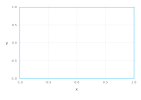

In [6]:
polyPlot(a)

Look - it's a square.  Awesome!





## Vector addition, scalar multiplication

We can add a vector to a polygon as follows

In [7]:
f = a + [ 1, 1 ] ;

Scalar multiplication will expand the set along rays through the origin

In [8]:
g = 1.5 * a ;

Becuase `polyPlot` also accepts polygon arrays, we can easily compare multiple `polygon` objects in the same plot

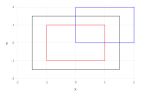

In [9]:
polyPlot( [a, f, g] )

## Approximate set sums

### Theory

The `polygon` package also allows us to compute approximate set sums of polygons.  Denote by $Z_1$ and $Z_2$ the vertices of two polygons $P_1$ and $P_2$.  If $H$ is a $m \times 2$ matrix of search directions, the extremal points of the two polygons in the search direction $h_i$ are given by the maximal projection of the vertices onto $h_i$:

$$ m^1_i = max Z_1 h_i' \qquad\qquad\qquad m^2_i = max Z_2 h_i' $$

Let $m^j=(m_i^j)$ be the vector of these projections and $m = m^1 + m^2$.  Then we can form a Judd-Yeltekin-Conklin outer aproximation to the set sum as the set with faces with normals given by the rows of $H$ and distances $m$:

$$
\begin{aligned}
    P &= \{ v_1 + v_2 | v_1 \in P_1, \ v_2 \in P_2 \} \\
        &\subseteq \{ z | h_i.z \le m_i \ \forall i \}
\end{aligned}
$$

We can also connect the vertices which maximize the projected distance vectors to form an inner approximation to the setsum.  Let $\hat z_i^j$ be the vertex of polygon $j$ which achieves the maximum distance in the direction $h_i$.  Then if $\hat P$ is the polygon defined by the vertices $\hat z_i = z_i^1 + z_i^2$:

$$ \hat P \subseteq P$$

Note that we could also just take the convex hull of all the possible point sums of the vertices $Z_1$ and $Z_2$ and recover a poterntially larger inner approximation.  But this is, in general, a fairly slow algorithm.  Projecting onto thevectors in $H$ is faster, as it involves less sorting.

### Practice

So, let's try these methods:

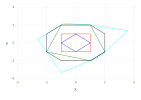

In [10]:
h = Polygon( pts=[ 0 1 ; 1 0 ; -1 0 ; 0 -1 ] )
exactdirs = [ a.dirs ; h.dirs ]
# The union of the face directions.  Will give an exact result
exact = setSum( a, h, exactdirs )
# The exact set sum
apxdirs = [ .1 1; .2 .8 ; -1 1 ; -.7 -.3 ; .4 -.6; .6 -.4  ]
outer = setSum( a, h, apxdirs ) ;
inner = setSum( a, h, apxdirs, false ) ;
polyPlot( [ a, h, exact, inner, outer ])

The polygons `a` and `h` are in red and blue in the centre of the diagram.  The exact set sum is in black, and is achieved when the search directions are the same as the union of nomals of the two sets.  The cyan and green polygons defin the inner and outer approximations to this.  Here, they are quite inaccuracte as there are few search directions and the differ in general from the true normals.  If we increase the number of search directions then we will get much better approximations.

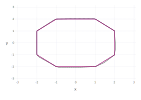

In [11]:
N = 40
theta = 2 * pi * rand( N )
manydirs = zeros( N, 2 )
for i in 1:N
    manydirs[i,:] = [ cos(theta[i]), sin(theta[i]) ]
end
manyouter = setSum( a, h, manydirs ) ;
manyinner = setSum( a, h, manydirs, false ) ;
polyPlot( [ exact, manyinner, manyouter ])

In this case, the inner approximation *is* the exact soluttion, as it picks out all the vertices perfectly

Not discussed here, but useful functions to know about: `setsum` can apply to arrays, `weightedSum` can perform a weighted set sum, and `deeDoop` removes duplicate and near-duplicate points from a polygon.

## Convex hull

The `polygon` package also provides a routine to generate a convex hull using the Graham Scan method

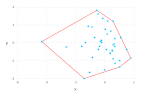

In [26]:
using Gadfly
using Colors
N = 40
srand(42)
manypts = randn( N, 2 )
chull( manypts )
ch = Polygon( pts = chull( manypts ) )
chplot = ch.pts[ [ 1:end; 1], : ]
plot( layer( x=manypts[:,1], y=manypts[:,2], Geom.point ), layer( x=chplot[:,1], y=chplot[:,2],  Geom.path,
          Theme(default_color=colorant"red") ) ) 

## Cropping polygons

Cropping polygons is a fundamental operation when calculating incentive-compatilbility with a fixed deviating payoff (when the deviating payoff is not fixed, we need to use linear programming or other methods to find the deviating payoff).  The `crop` function does this - chopping the polyon in either the x or y direction as required.

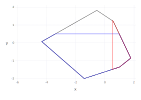

In [27]:
chr = crop( ch, 1, .5, true )
chdown = crop( ch, 2, .5, false )
polyPlot( [chr, chdown, ch])

## Unions

The `union` function forms the convex union of two polygons (or an array of polygons).

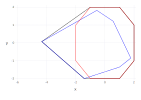

In [28]:
polyPlot( [ exact, ch, union( [ exact, ch ] ) ] )

## The Hausdorff distance

TBC: Still need to write code to reliably compute the Hausdorff distance between two sets.

## Extended example: Defining a value operator

Now let's apply this to a game-theoretic example, illustrating the usefulness of the functions in this package.  We will compute the set of equilibria of a version of the prisoner's dilemma with an exogenous state.  This is a little contrived, but demonstrates how the set sum, crop, and convex hull functions can be combined to easily code up game-theoretic set operators for much more sophisticated repeated and dynamic games.

The state $s$ is Markov with values $-.5$ or $0.5$ and symmetric transition matrix:

$$ P = \left[
\begin{array}{cc}
    .8 & .2 \\
    .2 & .8
\end{array}\right] $$

The payoff matrix is given by:

|             | Cooperate               | Defect 
|-------------|:-----------------------:|:-----------------:
|Cooperate    |  2 , 2                  | -1,3 - s
|Defect       |  3 + s , -1             | s, -s


This is the standard prisoner's dilemma, except that the relative values of defecting change with the state.  The  value of defecting always differs across the two player by one unit of payoff.  In a single-shot version of the game, this makes no difference.  The Nash equilibrium is always (D,D).  But in the repeated version of this game, the incentive compatibility constraints for the two players will move depending on the state.  When $s$ is positive, player 1 has more incentive to defect, and so equilibria which leave her relatively badly off will be less likely to be sustainable.

I denote the set of joint actions as $A$, and the vector of payoffs for a joint action $\in A$ by $\mathbf{u}(\mathbf{a})$

The worst-case equilibrium following defection is reversion to static Nash in every following period.  Denote by $\underline{\mathbf{V}}_i$ the vector of values of reversion to static Nash starting in state i, and $\mathbf{p}_i$ the row vector of conditional transition probabilities.  Then means that the incentive-compatible set values given an action $\mathbf{a}$ is bounded below in both dimensions byt the value of the minmax deviation:

$$
    IC_i(\mathbf{a}) = \{ \mathbf{v} = (v_1, v_2) \ | \ v_i \ge \max_{\hat a_i} (1-\beta) u_i( \hat a_i, a_j ) + \beta \mathbf{p}_i. [ \underline{\mathbf{V}}_1, \underline{\mathbf{V}}_2 ] \}
$$

Therefore, the set of equilibrium values of the game is the the fixed point $\bar W^1, \bar W^2$ of the operator $T$ mapping continuation values into incentive-compatible payoffs.  That is:

$$ 
\begin{align}
    ( \bar W^1, \bar W^2 ) &= T( \bar W^1, \bar W^2 ) \\
    \text{Where}
    \qquad\qquad
    T( W^1, W^2 ) &= \left( T_1( W^1, W^2 ), T_2( W^1, W^2 ) \right) \\
    \text{And} 
    \qquad\qquad
    T_i( W^1, W^2 ) &= \left\{ \mathbf{v} \in \mathbb R^2 | \ \exists \mathbf{a} \in A, \mathbf{w_i} \in W^i \ \text{s.t.} \ \mathbf{v} = (1-\beta) \mathbf{u}(\mathbf{a}) + \beta \mathbf{p}_i. [ \mathbf{w_1}, \mathbf{w_2} ] \ \text{and} \ \mathbf{v} \in IC_i(\mathbf{a})  \right\}
\end{align}
$$

To compute the fixed point, we first need to  calculate the matrix of state-dependent deviating payoffs.  This satisfies:

$$ 
\begin{align}
    [ \underline{\mathbf{V}}_1, \underline{\mathbf{V}}_2 ] &= (1-\beta) \left[ \begin{array}{cc} 0.5 & -0.5 \\ -0.5 & 0.5 \end{array}\right] + \beta P [ \underline{\mathbf{V}}_1, \underline{\mathbf{V}}_2 ] \\
    \Rightarrow \qquad
    [ \underline{\mathbf{V}}_1, \underline{\mathbf{V}}_2 ] &= ( 1 - \beta ) \left( 1 - \beta P \right)^{-1} \left[ \begin{array}{cc} 0.5 & -0.5 \\ -0.5 & 0.5 \end{array}\right]
\end{align}
$$

In [15]:
P = [ .8 .2; .2 .8 ]
U = [ .5 -.5 ; -.5 .5 ]
bet = 0.9
vlow = ( 1 - bet ) * ( ( eye(2) - bet * P ) \ U )

2x2 Array{Float64,2}:
  0.108696  -0.108696
 -0.108696   0.108696

We construct the operator $T$ in several stages.  First, the set of values for a given action pair without imposing the incentive-compatibility constraints:

In [29]:
N=40
dirs = zeros( N, 2 )
dirs[:,1] = [ cos(2 * pi * (i-1)/N) for i in 1:N ]
dirs[:,2] = [ sin(2 * pi * (i-1)/N) for i in 1:N ]
# Search directions.  Need to be careful to make sure that this is a matrix type.
U1(s) = [ 2 -1; 3+s s ]
U2(s) = [ 2 3-s; -1 -s ]
# The period payoff functions

function T_unc( W::Array{ Polygon, 1 }, s::Float64, a::Vector, outer = true)
# s is the value for the state and a is a vector containing the action indices
    u = [ U1(s)[a[1],a[2]] , U2(s)[a[1],a[2]] ] 
        # Period payoff
    s_idx = ( s == .5 ) ? 1 : 2
        # The index of s.  Required for selecting the right transition probability row
    return ( ( 1 - bet ) * u ) + ( bet * ( weightedSum( W, vec( P[ s_idx, :] ), dirs, outer ) ) )
end ;

Let's quickly test this using $W^1=W^2$ equal to the set of all period payoffs, and $\mathbf{a}=(C,C)$

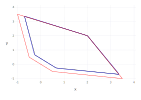

In [35]:
winit1 = Polygon( pts = [ 2.0 2.0; -1.0 3.5; 3.5 -1.0; -0.5 0.5 ; 0.5 -0.5 ] ) 
winit = [ winit1, winit1 ]
uncouter = T_unc( winit, .5, [1, 1] )
uncinner = T_unc( winit, .5, [1, 1], false )
polyPlot( [winit1, uncouter, uncinner ])

The black and blue polygons are the inner and outer approximations to the operator.  Then we can impose the incentive compatibility constraints to delivery the operator $T_i(W^1,W^2 | a )$.  

In [36]:
function T_a( W::Array{ Polygon, 1 }, s::Float64, a::Vector, vlow::Matrix, outer = true)
    # calcultes the incentive-compatible value set conditional on the action a
    unc = T_unc( W, s, a, outer )
        # The unconstrained set
    pddev = [ maximum( U1(s)[ :, a[2] ] ), maximum( U2(s)[ a[1], : ] ) ]
        # The deviating period payoffs
    s_idx = ( s == .5 ) ? 1 : 2
        # The index of s.  Required for selecting the right transition probability row
    dev = ( 1 - bet ) * pddev + bet * vlow[ s_idx, : ]'
        # The deviating payoff
    ic = crop( crop( unc, 1, dev[1] ), 2, dev[2] )
        # The incentive compatible set of payoffs\
    return ic
end ;

Again, let's give this a quick run out in an example case to check that it works ok.  Note that because we are trialing the state $s=0.5$, the set is not symmetric around $x=y$.  The temptation to deviate for player 1 is higher, and so the left-hand cutoff is higher.

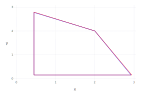

In [37]:
icouter = T_a( winit, .5, [1, 1], vlow )
icinner = T_a( winit, .5, [1, 1], vlow, false )
polyPlot( [icouter, icinner ])

We finaly define the operator $T$ by computing the union of incentive-compatible sets over all actions and then taking the convex union of the resulting sets. 

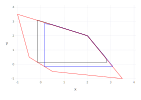

In [38]:
A_idx = [ 1 1; 1 2 ; 2 1; 2 2 ]
    # The matrix of action combinations

function T_operator( W::Array{ Polygon, 1 }, states::Vector, vlow, outer = true)
    # Forms the T operator
    out = [ union( [ T_a( W, s, vec(A_idx[j,:]), vlow, outer)::Polygon for j in 1:size(A_idx)[1] ] )::Polygon for s in states ]
    return out
end

polyPlot( [ winit1; T_operator( winit, [ .5 , -.5 ], vlow ) ] )

Recursive application of the $T$ operator will quickly deliver the eqiulibrium set.

TODO: Add convergence measure once the Hausdorff distance is complete

  4.149847 seconds (2.57 M allocations: 151.581 MB, 6.85% gc time)


  5.976322 seconds (2.97 M allocations: 402.685 MB, 10.79% gc time)


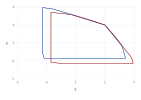

In [39]:
niter = 40
N=100
dirs = zeros( N, 2 )
dirs[:,1] = [ cos(2 * pi * (i-1)/N) for i in 1:N ]
dirs[:,2] = [ sin(2 * pi * (i-1)/N) for i in 1:N ]

function eqm( W::Array{Polygon,1}, states::Vector, outer::Bool=true )
    U = [ states' ; -states' ]
    vlow = ( 1 - bet ) * ( ( eye(2) - bet * P ) \ U )
    for ( i in 1:niter )
        Wnew = T_operator( W, states, vlow, outer )
        W = Wnew
    end
    return W
end

@time wouter = eqm( winit, [ .5, -.5 ] )
@time winner = eqm( winit, [ .5, -.5 ], false )

polyPlot( [ wouter; winner ] )

## Concluding remarks

The `Polygons` package provides basic functions for manipulating sets of values in repeated and dynamic games.  The example worked through here is quite trivial.  However, the basic buiding blocks can illustrated here can just as well be applied to more complicated games.  For example, where the punishment must be drawn from the equilibrium set, or where the evolution of the state depends on the action.